In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F
import sys

Добавляем путь к нашей библиотеке в переменную окружения

In [2]:
sys.path.insert(0, "../")

In [3]:
print(sys.path)

['../', '/home/sasha/BMM/bayes_deep_compression/examples', '/home/sasha/anaconda3/lib/python312.zip', '/home/sasha/anaconda3/lib/python3.12', '/home/sasha/anaconda3/lib/python3.12/lib-dynload', '', '/home/sasha/anaconda3/lib/python3.12/site-packages', '/home/sasha/anaconda3/lib/python3.12/site-packages/setuptools/_vendor', '/tmp/tmp6v_cw2kc']


Создаем простой классификтор, который будет нашей базовой моделью, кторую мы хотим обучить и запрунить

In [4]:

class Classifier(nn.Module): 
    def __init__(self, classes: int = 10): 
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        #self.dropout1 = nn.Dropout2d(0.25) 
        #self.dropout2 = nn.Dropout2d(0.5) 
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, classes) 
  
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x))) 
        #x = self.dropout1(x) 
        x = self.pool(F.relu(self.conv2(x))) 
        #x = self.dropout2(x) 
        x = x.view(-1, 64 * 7 * 7) 
        x = F.relu(self.fc1(x)) 
        x = self.fc2(x) 
        return x

Посмотрим как работают распределения в нашей библиотеке(Их не обязательно импортировать для работы и обучения байесовской модели)

Первый вид это привычные нам распределения на числа. Импортируем тот, который используется у нас в модели.

In [5]:
from src.methods.bayes.variational.distribution import LogUniformVarDist

Первый вид это привычные нам распределения на числа.

In [6]:
from src.methods.bayes.variational.net_distribution import VarBayesModuleNetDistribution #Необязательно импортировать для обучения, оно встроено в нашу байесовскую модель
from src.methods.bayes.base.net_distribution import BaseNetDistributionPruner #Также не обязательно для обучения, но нужен, если вы хотите запрунить модель

Мы можем инициализировать веса распределения просто из параметров модели. При этом используется рекомендуемая начальная инициализация параметров распределения

In [7]:
p = nn.Parameter(torch.tensor([0.0, 1.0])) 
LogUniformVarDist.from_parameter(p)

LogUniformVarDist(param_mus: torch.Size([2]), param_std_log: torch.Size([2]), scale_mus: torch.Size([2]), scale_alphas_log: torch.Size([2]))

Это три модуля являются основными для байесовского обучения

In [8]:
from src.methods.bayes.variational.net import LogUniformVarLayer, VarBayesNet #Первым модулоем мы оборачиваем те слои модели, которые мы хотим сделать байесовыми, второй модуль это сама байесовская сеть
from src.methods.bayes.variational.optimization import LogUniformVarKLLoss #Это лосс байесовской модели, который отвечает за тип обучения. Всегда рекомендуется использовать специализированный лосс, но для большинства распределений его нет

Загружаем датасет MNIST, на котором мы хотим обучить наш классификатор

In [9]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.42MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 219kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 864kB/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.30MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Посомтрим внимательнее как нужно создавать байесовскую сеть

Первым делом создадим нашу базовую модель

In [10]:
module = Classifier()

Далее мы часть слоев превратим в байесовски с помощью LogUniformVarBayesModule. И создадим список всех слоев nn.ModuleList([layer1, layer2, ...]), которые мы хотим обучить (в том чилсе слои, которые не являются байесовыми). Заметим, что можно обернуть и всю сеть целиком и передать список состоящий только из нее.

In [11]:
#bayes_model = BayesModule(module)
#var_module = LogUniformVarBayesModule(module)
var_module1 = LogUniformVarLayer(module.conv1)
#bayes_model = VarBayesModuleNet(module, nn.ModuleList([var_module])) #Первый аргумент базовая сеть, второй список всех слоев (где нужные из них являются байесовыми)
bayes_model = VarBayesNet(module, nn.ModuleDict({'conv1': var_module1}))

In [12]:

list(module.named_parameters())

[('conv2.weight',
  Parameter containing:
  tensor([[[[ 0.0051,  0.0443, -0.0515],
            [ 0.0142,  0.0112, -0.0043],
            [ 0.0119,  0.0147, -0.0322]],
  
           [[-0.0333, -0.0216,  0.0563],
            [-0.0500,  0.0431,  0.0271],
            [ 0.0336, -0.0206, -0.0539]],
  
           [[-0.0348,  0.0104,  0.0049],
            [ 0.0453,  0.0032,  0.0195],
            [-0.0460, -0.0035,  0.0529]],
  
           ...,
  
           [[-0.0367, -0.0261,  0.0311],
            [-0.0228, -0.0467, -0.0221],
            [ 0.0007,  0.0294, -0.0141]],
  
           [[ 0.0003,  0.0146, -0.0511],
            [ 0.0216, -0.0257,  0.0491],
            [-0.0030,  0.0078, -0.0418]],
  
           [[ 0.0204, -0.0195, -0.0276],
            [ 0.0428, -0.0102, -0.0485],
            [ 0.0585,  0.0419, -0.0113]]],
  
  
          [[[-0.0288, -0.0062,  0.0086],
            [-0.0111, -0.0235,  0.0182],
            [ 0.0084,  0.0055, -0.0392]],
  
           [[-0.0587, -0.0173, -0.0492],
     

Посомтрим на струкутру получившейся сети

In [13]:
print(bayes_model)

VarBayesNet(
  (base_module): Classifier(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=3136, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
  (module_dict): ModuleDict(
    (conv1): LogUniformVarLayer(
      (posterior_params): ParameterList(
          (0): Object of type: ParameterDict
          (1): Object of type: ParameterDict
        (0): ParameterDict(
            (param_mus): Parameter containing: [torch.FloatTensor of size 32x1x3x3]
            (param_std_log): Parameter containing: [torch.FloatTensor of size 32x1x3x3]
            (scale_alphas_log): Parameter containing: [torch.FloatTensor of size 32x1x3x3]
            (scale_mus): Parameter containing: [torch.FloatTensor of size 32x1x3x3]
        )
    

У выбранной сети отсутвует prior на параметры

In [14]:
bayes_model.prior

{'weight': None, 'bias': None, 'conv1.weight': None, 'conv1.bias': None}

Посомотрим как выглядит шаг обучения для сети

In [15]:
optimizer = optim.Adam(bayes_model.parameters(), lr=1e-3)

В целом он ничем не отличается от обычного шага, нам только нужно парвильно агрегировать лоссы от нескольких семплов на одном шаге

In [ ]:
#get one sample
#========
image, label = test_dataset[10]
y = bayes_model(torch.ones_like(image))
kl_loss = LogUniformVarKLLoss()
#========

#list of fit_loss for each sample (we have one sample)
fit_loss = [y.sum()]
 #list of dist_loss for each sample (we have one sample)
dist_loss = [kl_loss(posterior = bayes_model.posterior, prior = bayes_model.prior, param_sample_dict = bayes_model.weights)]
beta = 0.1 # scale factor betwenn dist_loss and data_loss
#aggregation result is stored in total_loss attribute, all others are provided for statistic of traininghow important each part is
aggregation_result = kl_loss.aggregate(fit_loss, dist_loss, beta) 
out = aggregation_result.total_loss # calculated loss for one step
#optimizer step
optimizer.zero_grad() 
out.backward() 
optimizer.step() 

Создать распределение сетей можно просто из распределения на параметры и базовой сети

In [ ]:
net_distributon = VarBayesModuleNetDistribution(bayes_model.base_module, bayes_model.posterior)
#Это прунер, которые зануляет веса в зависимости от плотности распределения при 0
net_distributon_pruner = BaseNetDistributionPruner(net_distributon)
#Здесь мы устанавливаем средние веса модели  
net_distributon.set_map_params()
#Пруним на основе определенного порога
net_distributon_pruner.prune(1.9)
#get basic model for evaluation
eval_model = net_distributon.get_model()

Мы получили модель с той же архитектурой что и изначальная

In [ ]:
print(eval_model.conv1.weight)

Parameter containing:
tensor([[[[-0.0902,  0.1707, -0.0707],
          [ 0.0186, -0.3256, -0.0603],
          [-0.2999,  0.2481, -0.1511]]],


        [[[-0.1627, -0.0081, -0.0716],
          [ 0.1351, -0.1272,  0.2407],
          [ 0.1409, -0.1332,  0.2248]]],


        [[[-0.3269,  0.2538,  0.2718],
          [-0.0718, -0.1498, -0.1461],
          [ 0.3001, -0.2323,  0.2633]]],


        [[[ 0.1695,  0.1394,  0.2616],
          [ 0.0581,  0.2032, -0.2948],
          [-0.3307, -0.2388, -0.0835]]],


        [[[ 0.0225,  0.1862, -0.0485],
          [-0.1546,  0.2089,  0.0221],
          [-0.0804, -0.2801, -0.2247]]],


        [[[-0.1759,  0.1806,  0.1717],
          [ 0.1532, -0.2478,  0.0651],
          [ 0.1325,  0.2898,  0.2971]]],


        [[[ 0.0267, -0.0907,  0.1670],
          [ 0.1165, -0.0227, -0.1577],
          [-0.2488,  0.0038,  0.1973]]],


        [[[ 0.1994, -0.1658, -0.2528],
          [-0.1690, -0.2176,  0.0138],
          [ 0.0286,  0.0010,  0.1582]]],


        [[

In [ ]:
bayes_model.state_dict()

OrderedDict([('base_module.conv1.weight',
              tensor([[[[-0.0902,  0.1707, -0.0707],
                        [ 0.0186, -0.3256, -0.0603],
                        [-0.2999,  0.2481, -0.1511]]],
              
              
                      [[[-0.1627, -0.0081, -0.0716],
                        [ 0.1351, -0.1272,  0.2407],
                        [ 0.1409, -0.1332,  0.2248]]],
              
              
                      [[[-0.3269,  0.2538,  0.2718],
                        [-0.0718, -0.1498, -0.1461],
                        [ 0.3001, -0.2323,  0.2633]]],
              
              
                      [[[ 0.1695,  0.1394,  0.2616],
                        [ 0.0581,  0.2032, -0.2948],
                        [-0.3307, -0.2388, -0.0835]]],
              
              
                      [[[ 0.0225,  0.1862, -0.0485],
                        [-0.1546,  0.2089,  0.0221],
                        [-0.0804, -0.2801, -0.2247]]],
              
              
   

Forward делается по последнему сохраненному сэмплу. Заметим, что мы нигде не копируем данные, и модели не инкапсулируется. Поэтому, чтобы отвязать, их неободимо скопировать

In [ ]:
print(bayes_model(torch.zeros_like(image)))
#print(bayes_model(torch.zeros_like(image), sample = False))
print(module(torch.zeros_like(image)))

tensor([[-0.1036,  0.0260, -0.1381, -0.1764, -0.0195, -0.0053, -0.0959, -0.0431,
         -0.0043,  0.0271]], grad_fn=<AddmmBackward0>)
tensor([[-0.1036,  0.0260, -0.1381, -0.1764, -0.0195, -0.0053, -0.0959, -0.0431,
         -0.0043,  0.0271]], grad_fn=<AddmmBackward0>)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Далее мы импортируем несколько модулей для обучения

In [ ]:
from src.methods.bayes.variational.trainer import VarBayesTrainer, VarTrainerParams, Beta_Scheduler_Plato, CallbackLossAccuracy #Сам тренер, Параметры тренера, Планировщик beta(коэффициент сооьношения между обычным лоссом и байесовским), и callback для метрики точности
from src.methods.report.base import ReportChain #Это просто список callback
from src.methods.report.variational import VarBaseReport #Этот модуль callback просто выводит каждый шаг данные от тренера

In [ ]:
beta = Beta_Scheduler_Plato()

In [ ]:
BATCH_SIZE=1000
EPOCHS=4000
LR = 1e-3 #5e-4
# Split the training set into training and validation sets 
VAL_PERCENT = 0.2 # percentage of the data used for validation 
SAMPLES = 10
BETA = 0.01 #5e-5 #0.01
BETA_FAC = 5e-1
PRUNE = 1.9#1.99, 2.1, 1.9
PLATO_TOL = 20

"""
base_module = Classifier()
var_module = LogUniformVarBayesModule(base_module)
model = VarBayesModuleNet(base_module, nn.ModuleList([var_module]))
"""
base_module = Classifier()
var_module1 = LogUniformVarLayer(base_module.conv1)
#bayes_model = VarBayesModuleNet(module, nn.ModuleList([var_module])) #Первый аргумент базовая сеть, второй список всех слоев (где нужные из них являются байесовыми)
model = VarBayesNet(base_module, nn.ModuleDict({'conv1': var_module1}))

optimizer = optim.Adam(model.parameters(), lr=LR)

#Первый лосс это обычный лосс на данные, второй лосс это лосс байесковской модели
fit_loss = nn.CrossEntropyLoss() 
kl_loss = LogUniformVarKLLoss()

#Используем планировщик коэффицента пропорциональности между fit_loss и kl_loss
beta = Beta_Scheduler_Plato(BETA, BETA_FAC, PLATO_TOL)
beta_KL = Beta_Scheduler_Plato(beta.beta, 1 / BETA_FAC, PLATO_TOL, ref = beta, threshold=1e-4)

#Данная функция будет выполнятся после каждого шага тренера, соответсвенно нам требуется сделать шаг планировщика и изменить соотвествующий коэффициент
def post_train_step(trainer: VarTrainerParams, train_result: VarBayesTrainer.TrainResult):
    beta.step(train_result.fit_loss)
    beta_KL.step(train_result.dist_loss)
    trainer.params.beta = float(beta)
    
#print(model.base_module.state_dict().keys())
val_size    = int(VAL_PERCENT * len(train_dataset)) 
train_size  = len(train_dataset) - val_size 

t_dataset, v_dataset = torch.utils.data.random_split(train_dataset,  
                                                        [train_size,  
                                                            val_size]) 

# Create DataLoaders for the training and validation sets 
train_loader = torch.utils.data.DataLoader(t_dataset,  
                                        batch_size=BATCH_SIZE,  
                                        shuffle=True, 
                                        pin_memory=True) 
eval_loader = torch.utils.data.DataLoader(v_dataset,  
                                        batch_size=BATCH_SIZE,  
                                        shuffle=False, 
                                        pin_memory=True) 

model.to(device) 
train_params = VarTrainerParams(EPOCHS, optimizer,fit_loss, kl_loss, SAMPLES, PRUNE, BETA, {'accuracy': CallbackLossAccuracy()})
#Если хотим сделать бету фиксированной, то нунжо убрать аргумент [post_train_step]
#trainer = VarBayesTrainer(train_params, ReportChain([VarBaseReport()]), train_loader, eval_loader, [post_train_step])
trainer = VarBayesTrainer(train_params, ReportChain([VarBaseReport()]), train_loader, eval_loader)
trainer.train(model)

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch [1/4000],Loss:25.163509368896484, KL Loss: 2312.739013671875. FitLoss: 2.0361196994781494,Accuracy:0.4752749999999999,Validation Loss:24.60753631591797,Validation Accuracy:0.719, Prune parameters: 0.0/320,Beta: 0.01
Epoch [2/4000],Loss:24.153614044189453, KL Loss: 2308.729248046875. FitLoss: 1.0663198232650757,Accuracy:0.7587874999999997,Validation Loss:23.739910125732422,Validation Accuracy:0.784, Prune parameters: 0.0/320,Beta: 0.01


KeyboardInterrupt: 

In [ ]:
print(model.state_dict())

OrderedDict([('module_list.0.posterior_params.0.param_mus', tensor([[[[ 2.5841e-07, -1.2233e-02,  7.9962e-03],
          [ 1.3414e-06,  4.4800e-03,  1.1717e-02],
          [ 2.4174e-03,  6.1303e-06, -6.3872e-03]]],


        [[[-2.4067e-06, -1.3908e-02, -2.3774e-05],
          [-2.2695e-06,  1.2359e-03,  9.2660e-03],
          [-9.2873e-07, -1.4729e-02,  3.6886e-07]]],


        [[[ 1.7811e-02, -1.4421e-02,  1.6615e-02],
          [-2.2942e-02, -3.1714e-05, -2.1503e-04],
          [-8.1395e-08, -1.0686e-04, -6.5693e-03]]],


        [[[ 2.5442e-03,  1.5579e-06, -2.7291e-04],
          [-1.1265e-07, -1.4138e-06, -4.5947e-07],
          [ 1.7760e-04, -2.5134e-02,  9.3481e-04]]],


        [[[-1.5268e-03,  3.9635e-04,  3.5783e-06],
          [ 1.2107e-06,  3.2627e-03,  8.3468e-03],
          [ 7.4476e-06, -2.1339e-02,  2.7009e-06]]],


        [[[ 1.5353e-02, -9.2420e-07, -3.7983e-06],
          [-2.5550e-06, -2.7675e-05, -1.0869e-04],
          [-1.4504e-06,  1.9404e-05, -8.4981e-07]]],


In [ ]:
base_module.state_dict()

OrderedDict()

In [ ]:
torch.save(model.state_dict(), 'model_bayes.pt' )

In [ ]:
model.prune({'threshold': 1.9})
print(model.prune_stats())

tensor(409356., device='cuda:0')


In [ ]:
model.prune([{'threshold': -2.2}])
print(model.prune_stats())

tensor(47343., device='cuda:0')


In [ ]:
module = Classifier()
var_module = LogUniformVarLayer(module)
model = VarBayesNet(module, nn.ModuleList([var_module]))

In [ ]:
model.state_dict()

OrderedDict([('module_list.0.posterior_params.0.param_mus',
              tensor([[[[-0.2737, -0.0213, -0.1784],
                        [-0.0449,  0.1339,  0.2884],
                        [ 0.1757,  0.2454,  0.0318]]],
              
              
                      [[[-0.2829,  0.1125,  0.2672],
                        [-0.0329,  0.1954,  0.2326],
                        [-0.0857, -0.2534,  0.0893]]],
              
              
                      [[[ 0.1525,  0.0669, -0.2533],
                        [-0.1758,  0.1672,  0.1206],
                        [ 0.0153,  0.1936, -0.3305]]],
              
              
                      [[[ 0.0107,  0.3182,  0.2102],
                        [-0.1029,  0.3132, -0.2125],
                        [-0.2650,  0.0061,  0.2422]]],
              
              
                      [[[-0.1922,  0.1445, -0.1445],
                        [-0.1862, -0.1703,  0.1814],
                        [-0.3061, -0.1629,  0.1818]]],
              


In [ ]:
model.load_state_dict(torch.load('model_bayes.pt'))
image1, label1 = test_dataset[10]
image2, label2 = test_dataset[11]
model(image1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
val_loss = 0.0
val_acc = 0.0
PRUNE = 1.0
test_loader = torch.utils.data.DataLoader(test_dataset,  
                                         batch_size=BATCH_SIZE,  
                                         shuffle=False, 
                                         pin_memory=True) 
kl_loss = LogUniformVarKLLoss()
trainer.params.prune_threshold = PRUNE
test_result = trainer.eval(model, test_loader)
acc = test_result.custom_losses['val_accuracy']
print(f'Loss:{test_result.val_loss}, KL Loss: {test_result.dist_loss}, FitLoss: {test_result.fit_loss}, Accuracy {acc}, Prune parameters: {test_result.cnt_prune_parameters}/{test_result.cnt_params}')

Loss:16906.90234375, KL Loss: 1690681.375, FitLoss: 0.09073139727115631, Accuracy 0.98, Prune parameters: 221821.0/421642


In [ ]:
model.to(device=device)
model.prune({'threshold': 1.0})
model.set_map_params()


In [ ]:
print(model.base_module.conv1.weight)

Parameter containing:
tensor([[[[ 4.2992e-03, -5.4342e-01, -0.0000e+00],
          [ 3.9089e-01, -0.0000e+00, -0.0000e+00],
          [ 8.2518e-01,  3.0815e-01, -2.3478e-02]]],


        [[[ 9.8153e-02,  0.0000e+00, -0.0000e+00],
          [ 4.4879e-01,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00, -0.0000e+00]]],


        [[[-1.4131e+00, -7.5729e-01, -0.0000e+00],
          [ 2.0788e-01,  4.6619e-01,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  2.6288e-01]]],


        [[[ 0.0000e+00,  9.8380e-01,  3.4592e-01],
          [-0.0000e+00,  4.0430e-01,  0.0000e+00],
          [-8.4115e-01, -3.8792e-01, -1.5979e-01]]],


        [[[ 2.0565e-01,  0.0000e+00,  2.3229e-01],
          [ 0.0000e+00,  6.6020e-01,  0.0000e+00],
          [-0.0000e+00, -0.0000e+00, -3.2411e-01]]],


        [[[-0.0000e+00,  3.8068e-01,  0.0000e+00],
          [-1.7023e-03,  7.2274e-01,  1.6451e-01],
          [-2.6313e-01,  0.0000e+00, -8.0280e-02]]],


        [[[ 0.0000e+00,  7.1311e-01,

Label: 5


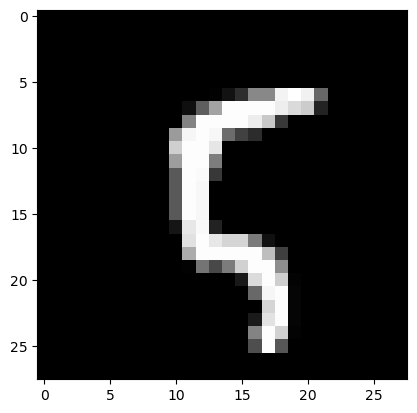

In [ ]:
image, label = test_dataset[100]
plt.imshow(image.permute(1, 2, 0), cmap="gray")
print("Label:", label)

In [ ]:
torch.max(model(image.cuda()).data, 1)

torch.return_types.max(
values=tensor([2.1405], device='cuda:0'),
indices=tensor([5], device='cuda:0'))